In [1]:
from random import random, choices, randint
from collections import Counter
from scipy.stats import binom
from statistics import mean,stdev, variance
import matplotlib.pyplot as plt
from numpy import sqrt, power
from copy import deepcopy
import numpy as np

In [2]:
#org and genome classes

class Genome:
    def __init__(self,sites,genomeLength):
        if sites is None:
            self.sites = self.initSites(genomeLength)
            self.length = genomeLength
        else:
            self.sites = sites
            self.length = len(sites)
          
        
    def initSites(self,genomeLength):
        # all zeroes; good for sawtooth or max-1
        return [0 for _ in range(genomeLength)]

    
    
class Organism:
    def __init__(self,genome,genomeLength,ancesterID = -1):
        if genome is None:
            self.genome = Genome(None,genomeLength)
        else:
            self.genome = genome
        self.offspringCount = 0
        self.fitness = None
        self.ancesterID = ancesterID
            
    
    def makeMutatedCopy(self,):
        global MU
        self.offspringCount += 1
        
        newOrganism = Organism(deepcopy(self.genome),self.genome.length)
        newOrganism.ancesterID = self.ancesterID
        for i in range(newOrganism.genome.length):
            if random() <= MU:
                sign = 1 if random() <= 0.5 else -1
                newOrganism.genome.sites[i] += sign
        return newOrganism
    
    
    def getFitness(self,evalFunc):
        if self.fitness is None:
            self.fitness = evalFunc(self)
        return self.fitness

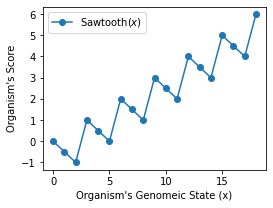

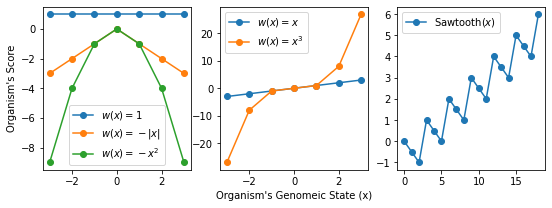

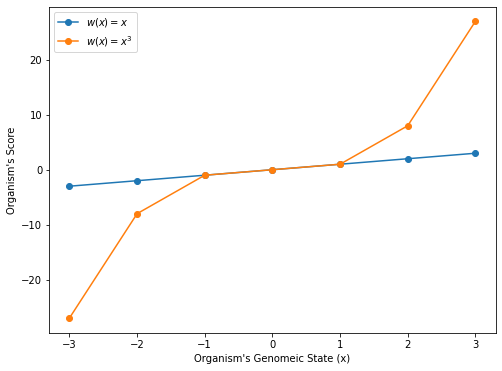

In [3]:
#fitness function and selection algorithms
def sawtooth(organism,plot=False):
    w = 2 #valley width
    d = 1 #valley depth
    r = 1 #fitness rise peak to peak
    
    if plot:
        anon = lambda v: v*(-d/w) + (v//(w+1))*(r + d + (d/w))
        plt.figure(figsize=(4,3))
        plt.plot([anon(v) for v in range(0,19)],marker="o",label="Sawtooth$(x)$")
        plt.ylabel("Organism's Score")
        plt.xlabel("Organism's Genomeic State (x)")
        plt.legend()
        plt.show()
        return
    
    x = sum(organism.genome.sites)
    x = x + w+1 #offset to next peak to avoid fitness zero on init
    
    return x*(-d/w) + (x//(w+1))*(r + d + (d/w))

sawtooth(None,plot=True)

def constFitness(organism):
    return 1

def linearFitness(organism):
    x = sum(organism.genome.sites)
#     return (2/5)*x
    return x

def tournament(population,size=2):
    global EVAL_FUNC
    return max(choices(population,k=size),key=lambda org: org.getFitness(EVAL_FUNC))

def roulette_select(population,batchSize,exp=1.05):
    global POP_SIZE, EVAL_FUNC
    MAX = max([org.getFitness(EVAL_FUNC) for org in population])
    F = [ power(exp,org.getFitness(EVAL_FUNC)-MAX) for org in population]
    S = sum(F)
    return choices(list(range(POP_SIZE)),k=batchSize,weights=[f/S for f in F])

def onePeak(organism):
    x = sum(organism.genome.sites)
#     return -(x**2)
#     return 2*x if x < 0 else -0.5*x
    return -abs(x)

def linearFitness4(organism):
    x = sum(organism.genome.sites)
#     return (2/5)*x
    return x**3


def onePeak4(organism):
    x = sum(organism.genome.sites)
#     return -(x**2)
#     return 2*x if x < 0 else -0.5*x
    return -(x**2)

start = -3
end = 3
fig, axs = plt.subplots(1,3,figsize=(9,3))
axs[0].plot([v for v in range(start,end+1)],[1 for v in range(start,end+1)],marker="o",label="$w(x)=1$")
axs[0].plot([v for v in range(start,end+1)],[-abs(v) for v in range(start,end+1)],marker="o",label="$w(x)=-|x|$")
axs[0].plot([v for v in range(start,end+1)],[-(v**2) for v in range(start,end+1)],marker="o",label="$w(x)=-x^2$")
axs[1].plot([v for v in range(start,end+1)],[v for v in range(start,end+1)],marker="o",label="$w(x)=x$")
axs[1].plot([v for v in range(start,end+1)],[v**3 for v in range(start,end+1)],marker="o",label="$w(x)=x^3$")
axs[0].set_ylabel("Organism's Score")
# axs[0].set_xlabel("Organism's Genomeic State (x)")
axs[1].set_xlabel("Organism's Genomeic State (x)")
axs[0].legend()
axs[1].legend()
w = 2 #valley width
d = 1 #valley depth
r = 1 #fitness rise peak to peak
anon = lambda v: v*(-d/w) + (v//(w+1))*(r + d + (d/w))
# axs[2].figure(figsize=(4,3))
axs[2].plot([anon(v) for v in range(0,19)],marker="o",label="Sawtooth$(x)$")
# axs[2].ylabel("Organism's Score")
# axs[2].set_xlabel("Organism's Genomeic State (x)")
axs[2].legend()
plt.savefig('FitnessFunctions.pdf', bbox_inches='tight')
plt.show()

start = -3
end = 3
plt.figure(figsize=(8,6))
plt.plot([v for v in range(start,end+1)],[v for v in range(start,end+1)],marker="o",label="$w(x)=x$")
plt.plot([v for v in range(start,end+1)],[v**3 for v in range(start,end+1)],marker="o",label="$w(x)=x^3$")
plt.ylabel("Organism's Score")
plt.xlabel("Organism's Genomeic State (x)")
plt.legend()
plt.show()

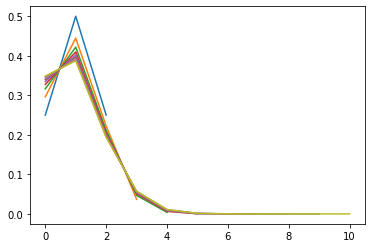

In [4]:
#selection strength components
DR = {}
def getDriftReference(initialPop,finalPop):
    key = (initialPop,finalPop)
    if key not in DR:
        DR[key] = [binom.pmf(x, finalPop, 1/initialPop) for x in range(finalPop+1)]
    return DR[key]

for testPopSize in [2,3,4,5,6,7,8,9,10]:
    plt.plot(getDriftReference(testPopSize,testPopSize)[:15])
# plt.yscale("log")
plt.show()


def getSigThreshold(DR,p=0.05):
    probVal = 1.0
    index_i = 0
    while probVal > p:
        probVal -= DR[index_i]
        index_i += 1
    return index_i


# MDR = {}
def moranDriftReference(N,maxOffCount,plot=False):
#     if N not in MDR:
    z = (N-1)/(2*N-1)
    gtr1 = lambda n: (N/(N-1))**2 * (z)**(n+1)
#         MDR[N] = [z if n==0 else gtr1(n) for n in range(maxOffCount+1)]
    if plot:
        return [z if n==0 else gtr1(n) for n in range(maxOffCount+1)]
    return [z if n==0 else gtr1(n) for n in range(max(N,maxOffCount)+1)] # MDR[N]


def emd(P,Q):
    assert len(P) == len(Q)
    EMD = [0]
    for i in range(len(P)):
        EMD.append(P[i]-Q[i]+EMD[-1])
    return sum([abs(d) for d in EMD])


# def getSS(offCounts_1d,initialPop,finalPop):
#     Counts = Counter(offCounts_1d)
#     Observed = [Counts[x]/initialPop if x in Counts else 0 for x in range(finalPop+1)]
#     return emd(getDriftReference(initialPop,finalPop),Observed)

def getSS(offCounts_1d):
    Counts = Counter(offCounts_1d)
    N_init = int(sum(Counts.values()))
    N_final = sum([int(k)*int(v) for k,v in Counts.items()])
    Observed = [Counts[x]/N_init if x in Counts else 0 for x in range(N_final+1)]
    return emd(getDriftReference(N_init,N_final),Observed)


def getSSMoran(offCounts_1d,N):
    Counts = Counter(offCounts_1d)
    Observed = [Counts[x]/N if x in Counts else 0 for x in range(max(N,max(Counts.keys()))+1)]
#     print("cnt",Counts)
#     print("obs",Observed)
#     print("ref",moranDriftReference(N,max(Counts.keys())))
    return emd(moranDriftReference(N,max(Counts.keys())),Observed)


def dictionaryReduce(listOfDict,target={}):
    #NOTE: if the target and listOfDict both lack a key,
    #      the updated target will not contain an entry for that key:
    #      this function aims to include zeros for missing keys
    #      therefore, some entries may lack zeros if they are not 
    #      represented in the initial set of keys provided; this function is
    #      best used when listOfDict is the final set of dics to be reduced
    maxKey = max([max(d.keys()) for d in listOfDict]+[max(list(target.keys())+[-1])])
    for dic in listOfDict:
        for key in range(maxKey+1):
            if key not in target:
                target[key] = []
            target[key].append(dic[key])
    return target

In [37]:
#parameters

POP_SIZE = 1000
GENOME_LENGTH = 1
MU = 1/20 #1.0/(2.5*(GENOME_LENGTH))
GENERATIONS = 5000
TSIZE = 2
REXP = float(5)

EVAL_FUNC = sawtooth
# EVAL_FUNC = constFitness
# EVAL_FUNC = linearFitness
# EVAL_FUNC = onePeak

In [41]:
# basic WF theory confirmation

population = [Organism(None,GENOME_LENGTH) for _ in range(POP_SIZE)]
dataLog = []
offCountAcc = {}

for generation in range(GENERATIONS):
    print(int(100*generation/GENERATIONS),"%",end="\r")
    aveFitness = mean([org.getFitness(EVAL_FUNC) for org in population])
    varFitness = stdev([org.getFitness(EVAL_FUNC) for org in population])
    
    #tournament
#     newPopulation = [tournament(population,size=TSIZE).makeMutatedCopy() for _ in range(POP_SIZE)]
    #roulette
    newPopulation = [population[orgNum].makeMutatedCopy() for orgNum in roulette_select(population,POP_SIZE,exp=REXP)]
    
    offspringCounts = [org.offspringCount for org in population]
    ##
#     maxCount = max(offspringCounts.keys())
#     valueBins = []
#     for xxx in range(maxCount):
#         valueBins.append(mean([org.genome.sites[0] for org in population if org.offspringCount == xxx])
#                         if offspringCounts[xxx] > 0 else None)
#     plt.plot(list(range(maxCount)),valueBins,marker="o")
#     plt.show()
    ##
    
    offCountAcc = dictionaryReduce([Counter(offspringCounts)],target=offCountAcc)
    
    selectionStrength = getSS(offspringCounts)
    
    dataLog.append((aveFitness,selectionStrength,varFitness))
    population = newPopulation
print()
    
aveFitLog, selStrLog, varFitLog = list(zip(*dataLog))


99 %


0.03275697744930845 0.025583842745165147


/tmp/ipykernel_10012/2584119504.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  axs[2].plot([s/v for s,v in zip(selStrLog,varFitLog)])


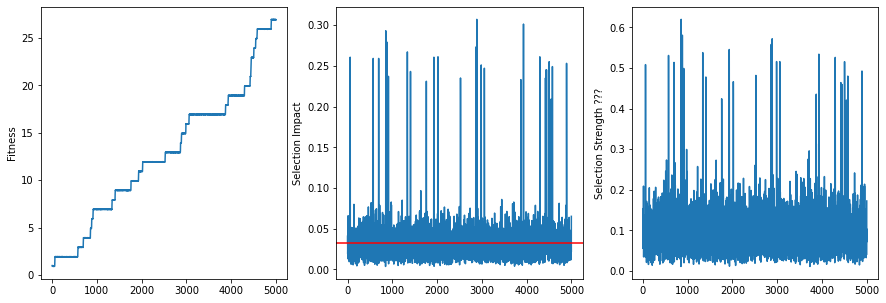

checkSum (1.0) 1.0
Larger than 5 offspring is signifigantly more than expected by drift.


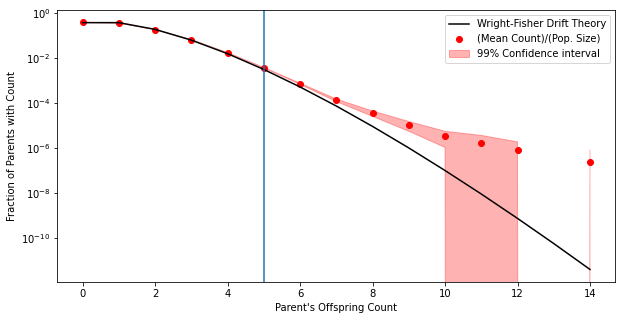

In [42]:
#plot WF results
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].set_ylabel("Fitness")
axs[0].plot(aveFitLog)
axs[1].set_ylabel("Selection Impact")
axs[1].plot(selStrLog)
axs[2].set_ylabel("Selection Strength ???")
axs[2].plot([s/v for s,v in zip(selStrLog,varFitLog)])
print(mean(selStrLog),stdev(selStrLog))
axs[1].axhline(mean(selStrLog),color="r")
plt.show()


print("checkSum (1.0)", sum([sum(V) for V in offCountAcc.values()]) / (GENERATIONS*POP_SIZE) )
meanDict = {k: mean(V)/POP_SIZE for k,V in offCountAcc.items()}
stdvDict = {k: stdev(V)/POP_SIZE for k,V in offCountAcc.items()}

plt.figure(figsize=(10,5))
plt.plot(getDriftReference(POP_SIZE,POP_SIZE)[:max(offCountAcc.keys())+1],
         label="Wright-Fisher Drift Theory",color="k")

sigthresh = getSigThreshold(getDriftReference(POP_SIZE,POP_SIZE),p=0.01)
print("Larger than",sigthresh,
      "offspring is signifigantly more than expected by drift.")
plt.axvline(sigthresh)
plt.scatter(meanDict.keys(),meanDict.values(),label="(Mean Count)/(Pop. Size)",color="r")

plt.fill_between(sorted(stdvDict.keys()),
                 [meanDict[k]+(2.58*stdvDict[k])/sqrt(GENERATIONS) for k in sorted(stdvDict.keys())],
                 [meanDict[k]-(2.58*stdvDict[k])/sqrt(GENERATIONS) for k in sorted(stdvDict.keys())],
                 alpha=0.3,color="r",label="99% Confidence interval")
plt.legend()
plt.title("")
plt.xlabel("Parent's Offspring Count")
plt.ylabel("Fraction of Parents with Count")
plt.yscale("log")
plt.show()

In [40]:
# basic MORAN theory confirmation

population = [Organism(None,GENOME_LENGTH,ancesterID = i) for i in range(POP_SIZE)]
aveFitLog = []
deathLog = []
ancesterListLog = []

for update in range(GENERATIONS*POP_SIZE):
    if update % POP_SIZE == 0:
        #log ancesterIDs
        ancesterListLog.append([org.ancesterID for org in population])
        #reset ancesterIDs
        for i in range(POP_SIZE):
            population[i].ancesterID = i
        
#     print(  (100*update)/(GENERATIONS*POP_SIZE)  ,"%",end="\r")
        aveFitness = mean([org.getFitness(EVAL_FUNC) for org in population])
        aveFitLog.append(aveFitness)
        
        
#     child = tournament(population,size=TSIZE).makeMutatedCopy()
    child = population[roulette_select(population,1,exp=REXP)[0]].makeMutatedCopy()
    
    deathID = randint(0,POP_SIZE-1)
    deathLog.append(deepcopy(population[deathID]))
    population[deathID] = child
#     population = [org for i,org in enumerate(population) if i != deathID] + [child]
    
    
print()


KeyboardInterrupt: 

In [ ]:
##plot moran results
plt.figure(figsize=(10,5))
plt.plot(aveFitLog)
plt.show()

selStrLog = []
offCountAcc = {}

debugPlotSet = []

for i in range(GENERATIONS):
    deathGen = deathLog[i*POP_SIZE:(i+1)*POP_SIZE]
    offspringCounts = Counter([org.offspringCount for org in deathGen])
    selectionStrength = getSSMoran(offspringCounts,POP_SIZE)
    selStrLog.append(selectionStrength)
    offCountAcc = dictionaryReduce([offspringCounts],target=offCountAcc)
    
#     print("Dist Below has SS:",selectionStrength)
#     plt.hist([org.offspringCount for org in deathGen])
#     plt.plot(np.multiply(POP_SIZE,moranDriftReference(POP_SIZE, max(offCountAcc.keys()),plot=True)),marker="o",label="Moran Drift Theory",color="k")
#     plt.show()
    debugPlotSet.append((selectionStrength,
                         tuple([org.offspringCount for org in deathGen]),
                         tuple(np.multiply(POP_SIZE,
                                           moranDriftReference(POP_SIZE, max(offspringCounts.keys()),plot=True)))))
selStrLogP = []
debugPlotSetP = []
prob_moran = 1
thrsh_geq_moran = 0
tempMoranDR = moranDriftReference(POP_SIZE, max(offCountAcc.keys()),plot=False)
while prob_moran > 0.01:
    prob_moran -= tempMoranDR[thrsh_geq_moran]
    thrsh_geq_moran += 1
print("offspring geq", thrsh_geq_moran, "larger than expected",prob_moran)
for i in range(GENERATIONS):
    deathGen = deathLog[i*POP_SIZE:(i+1)*POP_SIZE]
    offspringCounts = Counter([org.offspringCount for org in deathGen])
    selectionStrength = sum([1 for org in deathGen if org.offspringCount >= thrsh_geq_moran])
    selStrLogP.append(selectionStrength)
    
#     print("Dist Below has SS:",selectionStrength)
#     plt.hist([org.offspringCount for org in deathGen])
#     plt.plot(np.multiply(POP_SIZE,moranDriftReference(POP_SIZE, max(offCountAcc.keys()),plot=True)),marker="o",label="Moran Drift Theory",color="k")
#     plt.show()
    debugPlotSetP.append((selectionStrength,
                         tuple([org.offspringCount for org in deathGen]),
                         tuple(np.multiply(POP_SIZE,
                                           moranDriftReference(POP_SIZE, max(offspringCounts.keys()),plot=True)))))


    
    
plt.plot(selStrLog)
plt.show()
print("ave selstr",mean(selStrLog[5:]))
plt.hist(selStrLog)
plt.yscale("log")
plt.show()

# debugPlotSet.sort(reverse=True)
# for entry in debugPlotSet:
#     print("Dist Below has SS:",entry[0])
#     plt.hist(entry[1],bins=[-0.5]+[b+0.5 for b in range(len(entry[2]))])
#     plt.plot(entry[2],marker="o",label="Moran Drift Theory",color="k")
# #     plt.yscale("log")
#     plt.show()

start=0
stop=len(selStrLogP)
win = 10
AVEDATA = [mean(selStrLogP[max(start,i-win):min(i+win+1,stop)]) for i in range(start,stop)] # CORRECTED
plt.plot(selStrLogP,color="k")
plt.plot(AVEDATA,linewidth="2",color="r")
plt.show()

plt.hist(selStrLogP)
plt.yscale("log")
plt.show()

# debugPlotSetP.sort(reverse=True)
# for entry in debugPlotSetP:
#     print("Dist Below has SS:",entry[0])
#     plt.hist(entry[1],bins=[-0.5]+[b+0.5 for b in range(len(entry[2]))])
#     plt.plot(entry[2],marker="o",label="Moran Drift Theory",color="k")
# #     plt.yscale("log")
#     plt.show()



print(mean(selStrLog),stdev(selStrLog))
meanDict = {k: mean(V)/POP_SIZE for k,V in offCountAcc.items()}
stdvDict = {k: stdev(V)/POP_SIZE for k,V in offCountAcc.items()}

plt.figure(figsize=(10,5))
print(max(offCountAcc.keys()))
plt.plot(moranDriftReference(POP_SIZE, max(offCountAcc.keys()),plot=True),
         label="Moran Drift Theory",color="k")

plt.scatter(meanDict.keys(),meanDict.values(),label="(Mean Count)/(Pop. Size)",color="r")
plt.axvline(thrsh_geq_moran)
plt.fill_between(sorted(stdvDict.keys()),
                 [meanDict[k]+(2.58*stdvDict[k])/sqrt(GENERATIONS) for k in sorted(stdvDict.keys())],
                 [meanDict[k]-(2.58*stdvDict[k])/sqrt(GENERATIONS) for k in sorted(stdvDict.keys())],
                 alpha=0.3,color="r",label="99% Confidence interval")
plt.legend()
plt.title("")
plt.xlabel("Parent's Offspring Count")
plt.ylabel("Fraction of Parents with Count")
plt.yscale("log")
# plt.xlim(-5,20)
plt.show()

##########################
# ANCESTER_SS = []
# offCountAcc_ANCESTER = {}
# for entry in ancesterListLog:
#     ancesterCounts = Counter(entry)
#     for i in range(POP_SIZE):
#         if i not in ancesterCounts.keys():
#             ancesterCounts[i]=0
#     offspringCounts = Counter(ancesterCounts.values())
#     selectionStrength = getSSMoran(offspringCounts,POP_SIZE)
#     ANCESTER_SS.append(selectionStrength)
#     offCountAcc_ANCESTER = dictionaryReduce([offspringCounts],target=offCountAcc_ANCESTER)
    
# plt.plot(ANCESTER_SS)
# plt.show()
# plt.scatter(selStrLog[2:],ANCESTER_SS[2:])
# plt.show()

# meanDict = {k: mean(V)/POP_SIZE for k,V in offCountAcc_ANCESTER.items()}
# stdvDict = {k: stdev(V)/POP_SIZE for k,V in offCountAcc_ANCESTER.items()}

# plt.figure(figsize=(10,5))
# print(max(offCountAcc_ANCESTER.keys()))
# plt.plot(moranDriftReference(POP_SIZE, max(offCountAcc_ANCESTER.keys()),plot=True),
#          label="Moran Drift Theory",color="k")

# plt.scatter(meanDict.keys(),meanDict.values(),label="(Mean Count)/(Pop. Size)",color="r")
# # plt.axvline(thrsh_geq_moran)
# plt.fill_between(sorted(stdvDict.keys()),
#                  [meanDict[k]+(2.58*stdvDict[k])/sqrt(GENERATIONS) for k in sorted(stdvDict.keys())],
#                  [meanDict[k]-(2.58*stdvDict[k])/sqrt(GENERATIONS) for k in sorted(stdvDict.keys())],
#                  alpha=0.3,color="r",label="99% Confidence interval")
# plt.legend()
# plt.title("")
# plt.xlabel("Parent's Offspring Count")
# plt.ylabel("Fraction of Parents with Count")
# plt.yscale("log")
# # plt.xlim(-5,20)
# plt.show()


# fig, axs = plt.subplots(2,1,figsize=(12,8))
# axs[0].plot(list(range(start,stop)),aveFitLog[start:stop],label="Average Fitness")
# # axs[0].plot(list(range(start,stop)),maxData[start:stop],label="Max Fitness")
# axs[0].set_ylabel("Fitness Function Score")
# axs[0].legend()
# axs[1].plot(list(range(start,stop)),ANCESTER_SS[start:stop],color="k",label="Selection Strength")
# # axs[1].plot(list(range(start,stop)),AVEDATA,linewidth=2,color="r",label="Traveling Average")
# axs[1].set_xlabel("Generations")
# axs[1].set_ylabel("EMD($f_D$,$f$)")
# # axs[1].legend()
# plt.show()

In [11]:
# population size, effects on drift measure

EVAL_FUNC = constFitness
# popsizerange = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,100,150,200,250,500,750,1000,1500,2000,2500,5000,7500,10000]
popsizerange=[round(x) for x in np.logspace(0,4,25) if round(x) >=2]
popSSlog = []
GENERATIONS = 5000
MU = 1/8


for EVAL_FUNC in [constFitness, onePeak, linearFitness,onePeak4,linearFitness4]:
    for POP_SIZE in popsizerange:
        print(POP_SIZE)
        population = [Organism(None,GENOME_LENGTH) for _ in range(POP_SIZE)]
        dataLog = []
        offCountAcc = {}

        for generation in range(GENERATIONS):
    #         print(int(100*generation/GENERATIONS),"%",end="\r")
            aveFitness = mean([org.getFitness(EVAL_FUNC) for org in population])

            #tournament
#             newPopulation = [tournament(population,size=TSIZE).makeMutatedCopy() for _ in range(POP_SIZE)]
            #roulette
            newPopulation = [population[orgNum].makeMutatedCopy() for orgNum in roulette_select(population,POP_SIZE,exp=REXP)]
            
            offspringCounts = Counter([org.offspringCount for org in population])

            offCountAcc = dictionaryReduce([offspringCounts],target=offCountAcc)

            selectionStrength = getSS(offspringCounts)

            dataLog.append((aveFitness,selectionStrength))
            population = newPopulation
    
        aveFitLog, selStrLog = list(zip(*dataLog))

        #plot WF results
    #     fig, axs = plt.subplots(1,2,figsize=(10,5))
    #     axs[0].plot(aveFitLog)
    #     axs[1].plot(selStrLog)
        print(mean(selStrLog),stdev(selStrLog))
        popSSlog.append((mean(selStrLog),stdev(selStrLog)))
    #     axs[1].axhline(mean(selStrLog),color="r")
    #     plt.show()
        print()

2
0.5000000000000002 2.2202921806441065e-16

3
0.3158814814814816 0.23711274194296877

5
0.3149149440000004 0.12337032602236814

7
0.26620401557659973 0.12107776819467714

10
0.23029921738004155 0.09706604928331183

15
0.17927198134521483 0.0917525691225741

22
0.15682426181694645 0.07104404530777007

32
0.13395193220068172 0.057172943882052574

46
0.10846041220118771 0.04934909208218781

68
0.09159174570463224 0.04161118361164745

100
0.07599682243370437 0.03402259341081931

147
0.0637729505503143 0.02804138852911232

215
0.05150974971371091 0.022916036941928977

316


/home/vincent/.local/lib/python3.10/site-packages/scipy/stats/_discrete_distns.py:69: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


0.043150017244806375 0.019151881410699297

464
0.03614921409777707 0.015989707682179412

681
0.02948564903539317 0.013065223618333736

1000
0.024625255938230818 0.010716519814657556

1468
0.020030161442031964 0.008703365574720283

2154
0.016513835425782112 0.007291160097396497

3162
0.013745110928999183 0.006102524252274139

4642
0.011371723586003309 0.005032852143522632

6813
0.009397692437183861 0.004105406645902442

10000
0.007733354630233836 0.0034174204751993374

2
0.5000000000000002 2.2190302689678944e-16

3
0.3173629629629631 0.24180900226826724

5
0.3227630080000004 0.13064745265304195

7
0.26967503190483033 0.12444999434142619

10
0.23621969880096153 0.10335966110762726

15
0.18388055177577478 0.09366093781597716

22
0.1620095370042233 0.07632304730929275

32
0.13952282416712797 0.06202193266616232

46
0.11520453182207084 0.052691816590570255

68
0.09517331036032904 0.04409804496659972

100
0.08029641803997553 0.03700081643228451

147
0.06876818480449207 0.031263353049523754



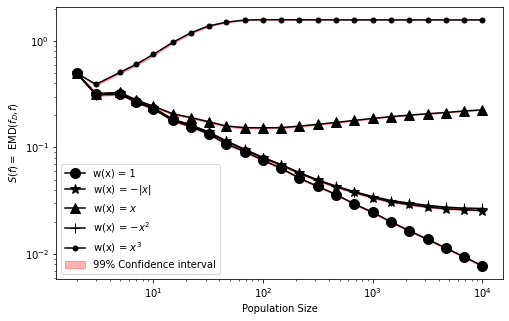

In [33]:
# population size, effects on drift measure (plots)
ssmean, ssstd = list(zip(*popSSlog)) 

plt.figure(figsize=(8,5))
lineLabels = ["w(x) = 1","w(x) = $-|x|$","w(x) = $x$","w(x) = $-x^2$","w(x) = $x^3$"]
lineMarkers = ["o","*","^","+","."]
CIlabels = ["99% Confidence interval","","","",""]
for i in range(5):
    start = i*len(popsizerange)
    stop = (i+1)*len(popsizerange)
    
    plt.plot(popsizerange,ssmean[start:stop],label=lineLabels[i],marker=lineMarkers[i],color="k",markersize=10)
    # plt.plot(popsizerange,ssstd,label="Standard Deviation")
for i in range(5):
    start = i*len(popsizerange)
    stop = (i+1)*len(popsizerange)
    
    plt.fill_between(popsizerange,
                     [m+(2.58*s)/sqrt(GENERATIONS) for m,s in popSSlog[start:stop]],
                     [m-(2.58*s)/sqrt(GENERATIONS) for m,s in popSSlog[start:stop]],
                     alpha=0.3,color="r",label=CIlabels[i])
plt.xlabel("Population Size")
plt.ylabel("$S(f) =$ EMD$(f_D$,$f)$")
plt.xscale("log")
plt.yscale("log")
plt.legend()
# plt.title("Population size vs average EMD($f_D$,$f$)")
plt.axhline(0,color="k")
plt.savefig('popSizeSS.pdf', bbox_inches='tight')
plt.show()

In [13]:
# MUR8, effects on drift measure

#murange = [1]+[1/(x*(GENOME_LENGTH*POP_SIZE)) for x in [1/2048,1/1024,1/512,1/256,1/128,1/64,1/32,1/16,1/8,1/4,1/2,1,2,4,8,16,32,64,128] if (x*(GENOME_LENGTH*POP_SIZE)) > 1]
murange = np.logspace(-5,0,25)
muSSlog = []
POP_SIZE = 500
GENERATIONS = 5000

for EVAL_FUNC in [constFitness, onePeak, linearFitness,onePeak4,linearFitness4]:
    for MU in murange:
        print(MU)
        population = [Organism(None,GENOME_LENGTH) for _ in range(POP_SIZE)]
        dataLog = []
        offCountAcc = {}

        for generation in range(GENERATIONS):
    #         print(int(100*generation/GENERATIONS),"%",end="\r")
            aveFitness = mean([org.getFitness(EVAL_FUNC) for org in population])

            #tournament
#             newPopulation = [tournament(population,size=TSIZE).makeMutatedCopy() for _ in range(POP_SIZE)]
            #roulette
            newPopulation = [population[orgNum].makeMutatedCopy() for orgNum in roulette_select(population,POP_SIZE,exp=REXP)]
            
            offspringCounts = Counter([org.offspringCount for org in population])

            offCountAcc = dictionaryReduce([offspringCounts],target=offCountAcc)

            selectionStrength = getSS(offspringCounts)

            dataLog.append((aveFitness,selectionStrength))
            population = newPopulation
    
        aveFitLog, selStrLog = list(zip(*dataLog))

        #plot WF results
    #     fig, axs = plt.subplots(1,2,figsize=(10,5))
    #     axs[0].plot(aveFitLog)
    #     axs[1].plot(selStrLog)
        print(mean(selStrLog),stdev(selStrLog))
        muSSlog.append((mean(selStrLog),stdev(selStrLog),mean([f-i for i,f in zip(aveFitLog[:-1],aveFitLog[1:])])))
    #     axs[1].axhline(mean(selStrLog),color="r")
    #     plt.show()
        print()

1e-05
0.0344870592385868 0.015121420444495177

1.6155980984398728e-05
0.03442136200474675 0.015125122094746512

2.6101572156825386e-05
0.03437853509347157 0.014822265298613297

4.216965034285822e-05
0.034253043874324346 0.014856826638273372

6.812920690579608e-05
0.03450440541246176 0.015397743387653717

0.00011006941712522103
0.03446211370651365 0.015303419909841933

0.00017782794100389227
0.03428105910378561 0.01517828606560855

0.0002872984833353666
0.034481440731938116 0.015484590035630059

0.0004641588833612782
0.034403454014570706 0.015152127797361756

0.0007498942093324559
0.03409191646565014 0.015274161099513702

0.001211527658628589
0.03441389735206734 0.015296600618842818

0.0019573417814876615
0.03416022381303514 0.01515270366521065

0.0031622776601683794
0.03443593957780763 0.015659334756330055

0.00510896977450693
0.03425583580506991 0.015139238693158634

0.00825404185268019
0.03447290123559499 0.015268804442626412

0.01333521432163324
0.034360031045048194 0.01545569152530

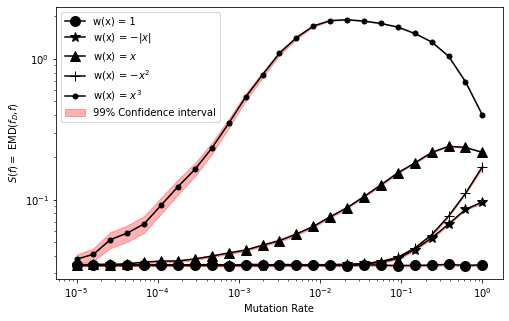

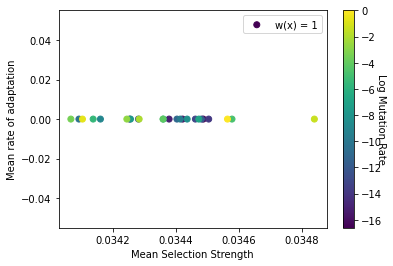

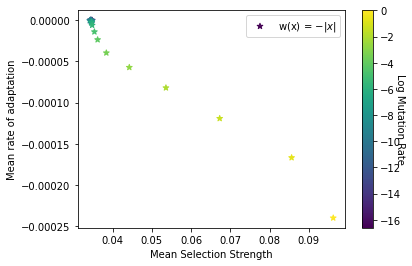

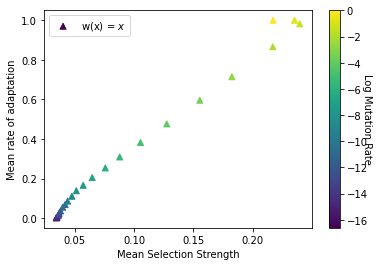

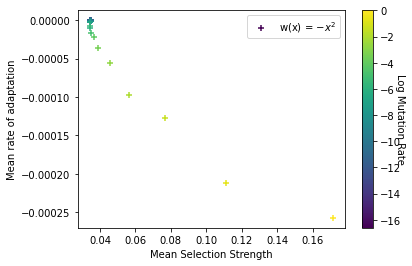

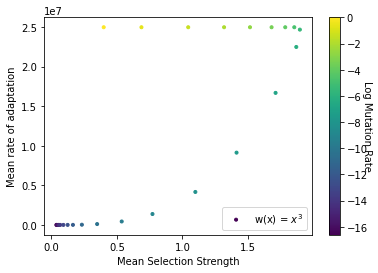

In [34]:
# MUR8, effects on drift measure (plots)
ssmean, ssstd, roamean = list(zip(*muSSlog)) 

plt.figure(figsize=(8,5))
lineLabels = ["w(x) = 1","w(x) = $-|x|$","w(x) = $x$","w(x) = $-x^2$","w(x) = $x^3$"]
lineMarkers = ["o","*","^","+","."]
CIlabels = ["99% Confidence interval","","","",""]
for i in range(5):
    start = i*len(murange)
    stop = (i+1)*len(murange)
    
    plt.plot(murange,ssmean[start:stop],label=lineLabels[i],marker=lineMarkers[i],color="k",markersize=10)
    # plt.plot(popsizerange,ssstd,label="Standard Deviation")
for i in range(5):
    start = i*len(murange)
    stop = (i+1)*len(murange)
    
    plt.fill_between(murange,
                     [m+(2.58*s)/sqrt(GENERATIONS) for m,s,_ in muSSlog[start:stop]],
                     [m-(2.58*s)/sqrt(GENERATIONS) for m,s,_ in muSSlog[start:stop]],
                     alpha=0.3,color="r",label=CIlabels[i])
plt.xlabel("Mutation Rate")
plt.ylabel("$S(f) =$ EMD$(f_D$,$f)$")
plt.xscale("log")
plt.yscale("log")
plt.legend()
# plt.title("mutation rate vs average selection strength")
plt.axhline(0,color="k")
plt.savefig('mutationRateSS.pdf', bbox_inches='tight')
plt.show()



for i in range(5):
    start = i*len(murange)
    stop = (i+1)*len(murange)
    
#     plt.plot(murange,ssmean[start:stop],label=lineLabels[i],marker=lineMarkers[i],color="k",markersize=10)
    plt.scatter(ssmean[start:stop],roamean[start:stop],label=lineLabels[i],marker=lineMarkers[i],c=np.log2(murange))#,color="k",markersize=10)
    cb = plt.colorbar()
    cb.set_label("Log Mutation Rate", rotation=270)
    plt.legend()
    plt.xlabel("Mean Selection Strength")
    plt.ylabel("Mean rate of adaptation")
#     plt.yscale("symlog")
#     plt.xscale("symlog")
    plt.show()

In [ ]:
# WF three tiers of selection

meanSelections = []

funcCounter = 0
for EVAL_FUNC in [constFitness, onePeak, linearFitness]:
    population = [Organism(None,GENOME_LENGTH) for _ in range(POP_SIZE)]
    dataLog = []
    offCountAcc = {}
    for generation in range(GENERATIONS):
        print(funcCounter,int(100*generation/GENERATIONS),"%",end="\r")
        aveFitness = mean([org.getFitness(EVAL_FUNC) for org in population])
        newPopulation = [tournament(population,size=TSIZE).makeMutatedCopy() for _ in range(POP_SIZE)]
        offspringCounts = Counter([org.offspringCount for org in population])
        offCountAcc = dictionaryReduce([offspringCounts],target=offCountAcc)
        selectionStrength = getSS(offspringCounts,POP_SIZE,POP_SIZE)
        dataLog.append((aveFitness,selectionStrength))
        population = newPopulation
    print()
    funcCounter += 1
    
    aveFitLog, selStrLog = list(zip(*dataLog))
    fig, axs = plt.subplots(1,2,figsize=(10,5))
    axs[0].plot(aveFitLog)
    axs[1].plot(selStrLog)
    print(mean(selStrLog),stdev(selStrLog))
    meanSelections.append((mean(selStrLog),stdev(selStrLog)))
    axs[1].axhline(mean(selStrLog),color="r")
    plt.show()
    


In [ ]:
#sawtooth with 3 tiers plotted

meanSelections = []
population = [Organism(None,GENOME_LENGTH) for _ in range(POP_SIZE)]
dataLog = []
offCountAcc = {}
EVAL_FUNC = sawtooth
EVAL_FUNC(None,plot=True)
for generation in range(GENERATIONS):
    print(int(100*generation/GENERATIONS),"%",end="\r")
    aveFitness = mean([org.getFitness(EVAL_FUNC) for org in population])
    varFitness = variance([org.getFitness(EVAL_FUNC) for org in population])
    newPopulation = [tournament(population,size=TSIZE).makeMutatedCopy() for _ in range(POP_SIZE)]
    offspringCounts = Counter([org.offspringCount for org in population])
    offCountAcc = dictionaryReduce([offspringCounts],target=offCountAcc)
    selectionStrength = getSS(offspringCounts,POP_SIZE,POP_SIZE)
    dataLog.append((aveFitness,varFitness,selectionStrength))
    population = newPopulation
print()

aveFitLog, varFitLog, selStrLog = list(zip(*dataLog))



In [ ]:
#plot WF results
fig, axs = plt.subplots(1,2,figsize=(20,10))
axs[0].plot(aveFitLog)
axs[1].plot(selStrLog)
axs[1].axhline(mean(selStrLog),color="m")
for m in meanSelections:
    axs[1].axhline(m[0],color="r")
    axs[1].axhline(m[0]+(2.58*m[1])/sqrt(GENERATIONS),color="g")
    axs[1].axhline(m[0]-(2.58*m[1])/sqrt(GENERATIONS),color="g")
plt.show()

plt.scatter(selStrLog,varFitLog)
plt.xlabel("selection strength")
plt.ylabel("pop variance")
plt.show()

In [ ]:
#plot WF results
start = 2300
stop = 2350

win = 10
AVEDATA = [mean(selStrLog[max(0,i-win):min(i+win+1,stop-start)]) for i in range(stop-start)]

fig, axs = plt.subplots(1,2,figsize=(20,10))
axs[0].plot(list(range(start,stop)),aveFitLog[start:stop])
axs[1].plot(list(range(start,stop)),selStrLog[start:stop])
axs[1].plot(list(range(start,stop)),AVEDATA,linewidth=2.5,color='#55FF55')
# axs[1].axhline(mean(selStrLog[start:stop]),color="y")
for m in meanSelections:
    axs[1].axhline(m[0],color="y")
    axs[1].axhline(m[0]+(2.58*m[1])/sqrt(GENERATIONS),color="r")
    axs[1].axhline(m[0]-(2.58*m[1])/sqrt(GENERATIONS),color="r")
plt.show()